In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-9ga240gt
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-9ga240gt
  Resolved https://github.com/tensorflow/docs to commit be897e71ee8795aa8725c5efb9f9ac626304243b
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.5.3.6908-py3-none-any.whl size=182514 sha256=a013b47c485b8fb014220eb16eaef7cb6e542e625e4896c3c8b7dd3bbee124da
  Stored in directory: /tmp/pip-ephem-wheel-cache-tkn18ql4/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

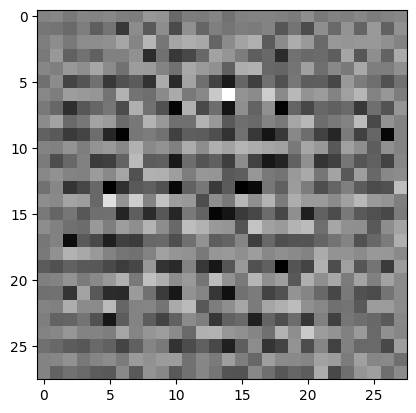

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00318927]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [ ]:

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Declare Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#Mouting the drive to load a simple dataset stored on the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Checkpoints

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)


In [ ]:
#Training Loop Starts Here

#Define the no. of Epochs for training
EPOCHS = [50]
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

images/


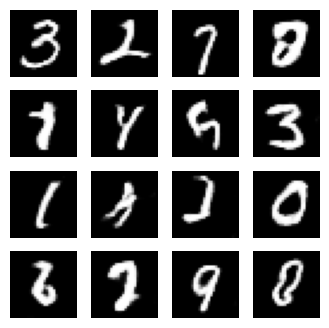

In [ ]:
import time
from IPython import display

def generate_and_save_images(model, epoch, test_input, save_dir='images/'):
  print(save_dir)
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  os.makedirs(save_dir, exist_ok=True)

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


def train(dataset, epochs):
  for num_epochs in epochs:
      for epoch in range(num_epochs):
          start = time.time()

          for image_batch in dataset:
              train_step(image_batch)

    # Produce images for the GIF as you go
          display.clear_output(wait=True)
    #generate_and_save_images(generator, epoch + 1, seed)


    # Save the model every 15 epochs
          if (epoch + 1) % 15 == 0:
              checkpoint.save(file_prefix=checkpoint_prefix)
     # Save the model after 50 epochs
          if (epoch + 1) == 50:
               generate_and_save_images(generator, epoch + 1, seed)

          print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

 # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           sum(epochs),
                           seed)
  #Save for each set of epochs
  checkpoint.save(file_prefix=checkpoint_prefix)

train(train_dataset, EPOCHS)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Create a GIF


# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)